## Задача понижения размерности. Метод главных компонент

Понижать размерность может быть полезно, чтобы: 
- бороться с «проклятием размерности»
- генерировать новые, более информативные признаки
- строить более простые и менее ресурсоемкие модели

Один из самых простых и понятных методов, которые используют для понижения размерности, — это метод главных компонент (PCA).

#### Теория

Кратко вспомним, что делает этот метод.

Пусть $X$ &mdash; матрица объекты-признаки размера $n \times D$, с нулевым средним каждого признака. 
Мы хотим перейти в новое признаковое пространство размерности $n \times d$, $d<D$,  сохранив при этом как можно больше информации из исходного набора данных.

Введем некоторый вектор весов $w$. Тогда
$Xw$ задает величину проекций всех объектов на этот вектор. Нам нужно найти вектор $w$, 
который дает наибольшую дисперсию полученных проекций (что связано с нашим желанием потерять как можно меньше информации при переходе в новое пространство).
Формально задачку можно записать так: 

$$
    \max_{w: \|w\|=1} \| Xw \|^2 =  \max_{w: \|w\|=1} w^T X^T X w
$$

Можно показать, что решением задачи является собственный вектор матрицы $X^T X$ с наибольшим собственным
значением. Мы получили первую главную компоненту. Чтобы получить $d$ компонент, придется повторить этот процесс $d$ раз, каждый последующий раз накладывая ограничение на ортогональность искомой компоненты всем, найденным на предыдущих шагах. Затем можно посчитать проекции матрицы $X$ на каждую из компонент и таким образом перейти в новое признаковое пространство.

#### PCA на плоскости

Для начала посмотрим на метод PCA на плоскости.

Попробуем специально сделать один из признаков более значимым (имеющим больший разброс значений) и проверим, что PCA это обнаружит. Сгенерируем выборку из двухмерного гауссовского распределения. Обратите внимание, что выборка
изначально выбирается центрированной.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(314512)

data_synth_1 = np.random.multivariate_normal(
    mean=[0, 0], 
    cov=[[4, 0], 
         [0, 1]],
    size=1000)

Теперь изобразим точки выборки на плоскости и применим к ним PCA для нахождения главных компонент.
В результате работы PCA из sklearn в `dec.components_` будут лежать главные направления (нормированные), а в `dec.explained_variance_` &mdash; дисперсия, которую объясняет каждая компонента. Изобразим на нашем графике эти направления, умножив их на дисперсию для наглядного отображения их
значимости.

In [7]:
dec = PCA()
dec.fit(data_synth_1)
dec.components_

array([[-0.99995704, -0.00926927],
       [-0.00926927,  0.99995704]])

In [8]:
dec.explained_variance_

array([4.06379269, 0.95373144])

In [9]:
dec.explained_variance_ratio_

array([0.80991991, 0.19008009])

In [10]:
dec.transform(data_synth_1)

array([[-0.13463008, -0.74775044],
       [ 3.75479642,  1.01689462],
       [ 3.14019083, -0.14760698],
       ...,
       [-2.6515338 , -1.6741033 ],
       [ 2.21190222,  1.52616799],
       [ 0.8956986 , -0.57470515]])

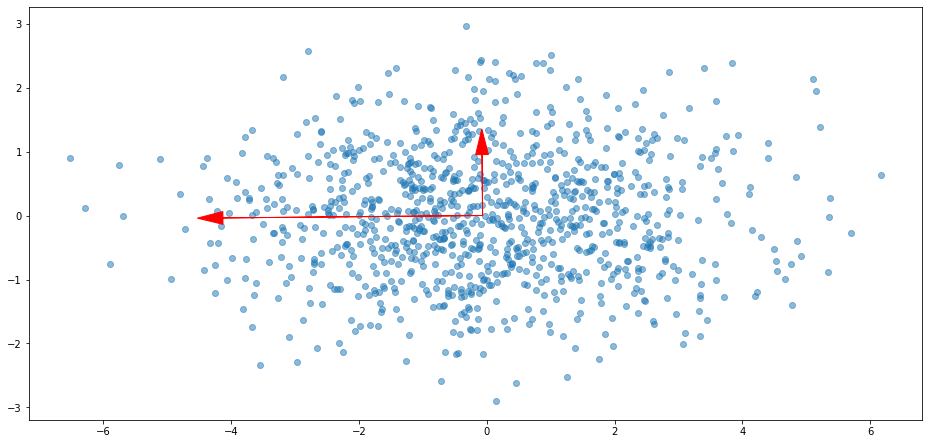

In [3]:
from sklearn.decomposition import PCA


def PCA_show(dataset):
    plt.scatter(*zip(*dataset), alpha=0.5)
    
    dec = PCA()
    dec.fit(dataset)
    ax = plt.gca()
    for comp_ind in range(dec.components_.shape[0]):
        component = dec.components_[comp_ind, :]
        var = dec.explained_variance_[comp_ind]
        start, end = dec.mean_, component * var
        ax.arrow(start[0], start[1], end[0], end[1],
                 head_width=0.2, head_length=0.4, fc='r', ec='r')
    
    ax.set_aspect('equal', adjustable='box')

plt.figure(figsize=(16, 8))
PCA_show(data_synth_1)

Видим, что PCA правильно определил направление наибольшего разброса данных. Но это, конечно, можно было сделать, просто посчитав
дисперсию каждого признака. Повернем наши данные на некоторый фиксированный угол и проверим,
что для PCA это ничего не изменит.

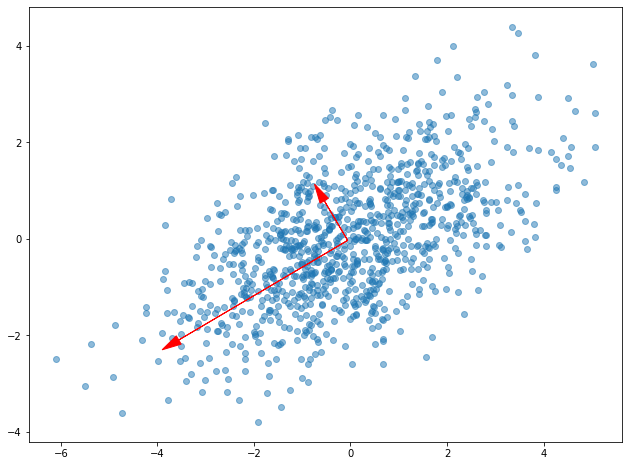

In [11]:
angle = np.pi / 6
rotate = np.array([
        [np.cos(angle), - np.sin(angle)],
        [np.sin(angle), np.cos(angle)],
    ])
data_synth_2 = rotate.dot(data_synth_1.T).T

plt.figure(figsize=(16, 8))
PCA_show(data_synth_2)

Ниже пара примеров, где PCA отработал не так хорошо (в том смысле, что направления задают не очень хорошие признаки, не отображающие структуру данных).

**Упражнение.** Объясните, почему так произошло.

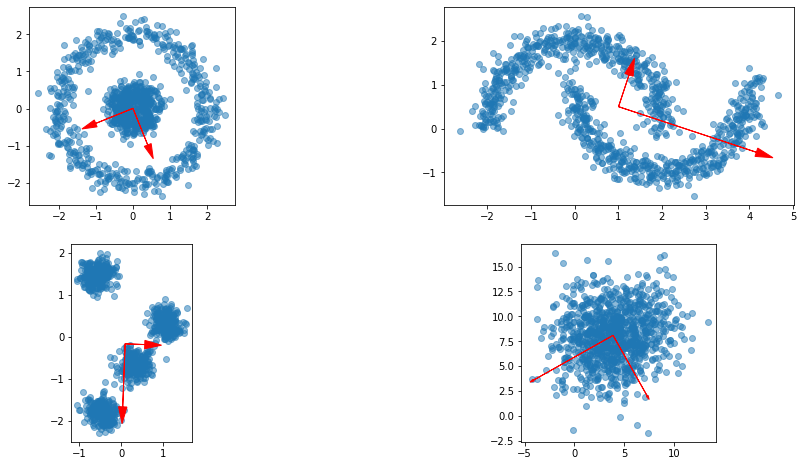

In [5]:
from sklearn.datasets import make_circles, make_moons, make_blobs

np.random.seed(54242)
data_synth_bad = [
    make_circles(n_samples=1000, factor=0.2, noise=0.1)[0]*2,
    make_moons(n_samples=1000, noise=0.1)[0]*2,
    make_blobs(n_samples=1000, n_features=2, centers=4)[0]/5,
    np.random.multivariate_normal(
        mean=[4, 8], 
        cov=[[9, 1], 
             [1, 8]],
        size=1000),
]


plt.figure(figsize=(16,8))
rows, cols = 2, 2
for i, data in enumerate(data_synth_bad):
    plt.subplot(rows, cols, i + 1)
    PCA_show(data)

#### Лица людей

Рассмотрим датасет с фотографиями лиц людей и применим к его признакам PCA.

Ниже изображены примеры лиц из базы, а последняя картинка &mdash; это "среднее лицо".

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /Users/vladimiromelyusik/scikit_learn_data


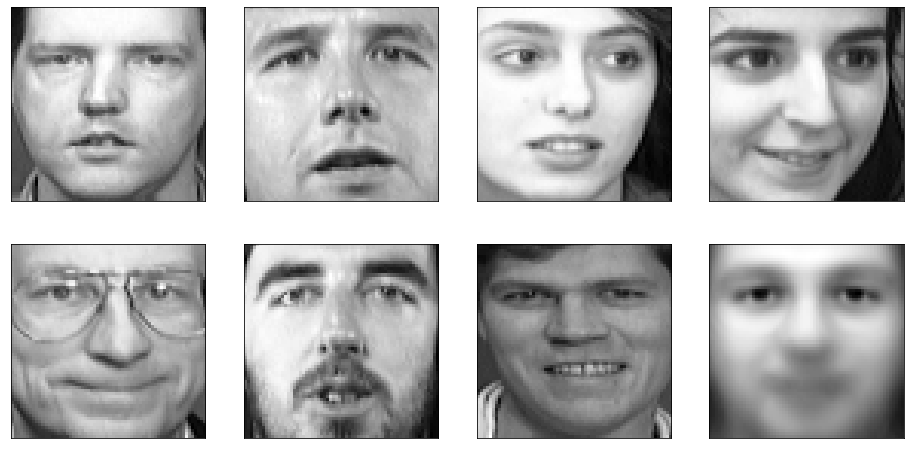

In [13]:
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces(shuffle=True, random_state=432542)
faces_images = faces.data
faces_ids = faces.target
image_shape = (64, 64)
    
mean_face = faces_images.mean(axis=0)

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples - 1):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(faces_images[i, :].reshape(image_shape), interpolation='none',
               cmap='gray')
    plt.xticks(())
    plt.yticks(())
    
plt.subplot(rows, cols, n_samples)
plt.imshow(mean_face.reshape(image_shape), interpolation='none',
           cmap='gray')
plt.xticks(())
_ = plt.yticks(())

Теперь найдем главные компоненты.

In [14]:
faces_images.shape

(400, 4096)

In [15]:
64 * 64

4096

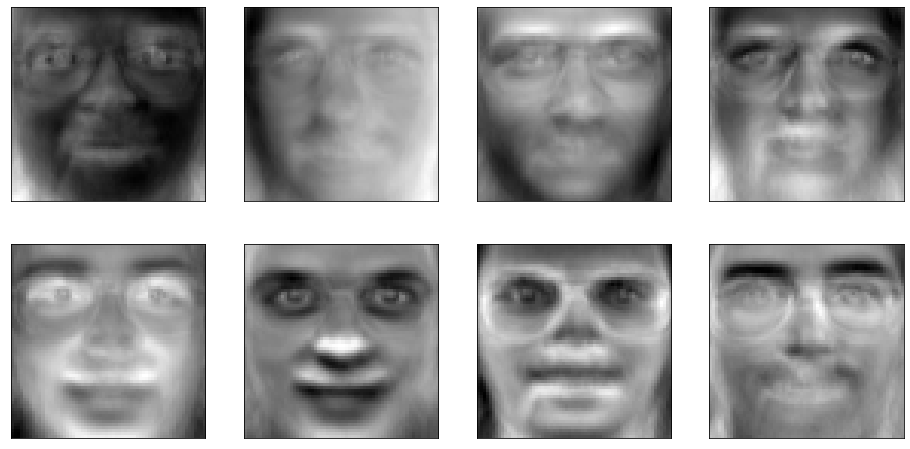

In [16]:
red = PCA()
faces_images -= mean_face
red.fit(faces_images)

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(red.components_[i, :].reshape(image_shape), interpolation='none',
               cmap='gray')
    plt.xticks(())
    plt.yticks(())

Получилось жутковато, что уже неплохо, но есть ли от этого какая-то польза?

Во-первых, новые признаки дают более высокое качество классификации.

Во-вторых, их можно использовать для компактного хранения данных. Для этого объекты трансформируются
в новое пространство, и из него выкидываются самые незначимые признаки.

Ниже приведены результаты сжатия в 10 раз.

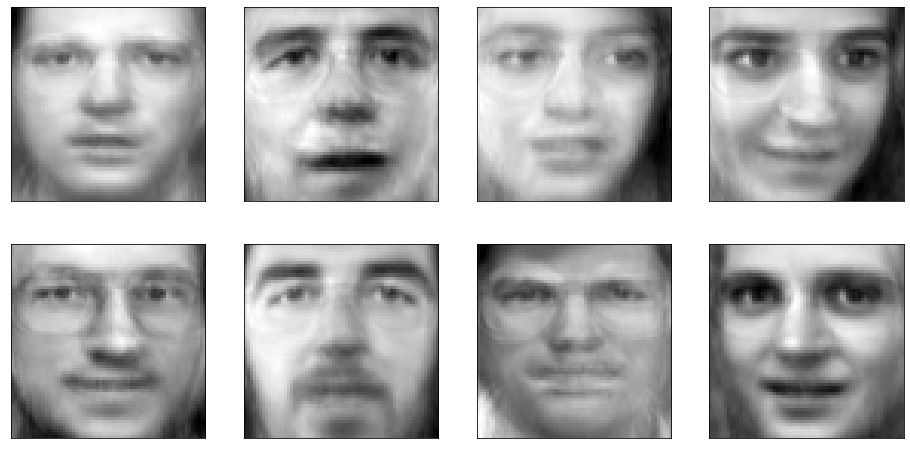

In [33]:
base_size = min(image_shape[0] * image_shape[1], faces_images.shape[0])

def compress_and_show(compress_ratio):
    red = PCA(n_components=int(base_size * compress_ratio))
    red.fit(faces_images)

    faces_compressed = red.transform(faces_images)
    faces_restored = red.inverse_transform(faces_compressed) + mean_face

    plt.figure(figsize=(16, 8))
    rows, cols = 2, 4
    n_samples = rows * cols
    for i in range(n_samples):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(faces_restored[i, :].reshape(image_shape), interpolation='none',
                   cmap='gray')
        plt.xticks(())
        plt.yticks(())
        
compress_and_show(0.1)

И даже при сжатии в 20 раза лица остаются узнаваемыми.

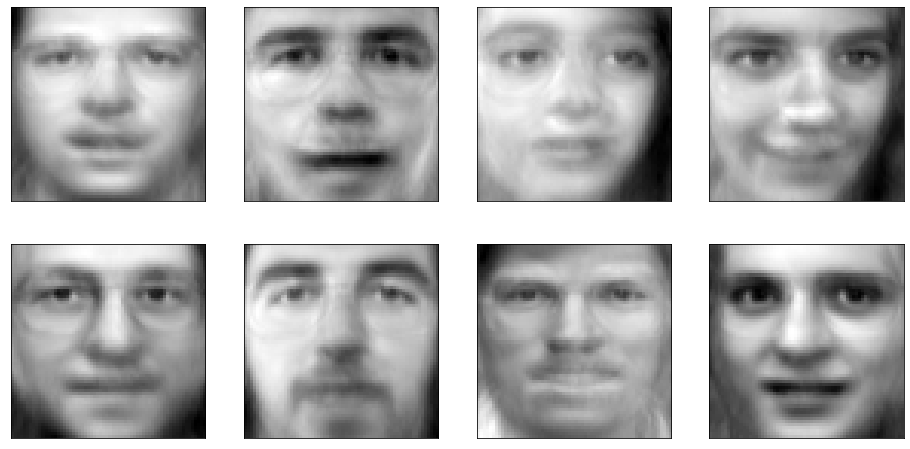

In [34]:
compress_and_show(0.05)